In [1]:
import numpy as np
import pandas as pd
import pymssql
import pyodbc
from datetime import datetime, timedelta
import re
from dateutil.parser import parse
import glob
import argparse
import sys
import openpyxl as opx
import xlrd
import time
import math
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.rc("font", family = "Malgun Gothic")
from copy import deepcopy


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch

# Class

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]        

In [3]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [40]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
#         print(train_seq)
        train_label = input_data[i+output_window:i+tw+output_window]
#         print(train_label)
        inout_seq.append((train_seq ,train_label))
#         print(inout_seq)
    return torch.FloatTensor(inout_seq)

In [5]:
def get_data(data, split):
    """Split ratio of training data"""

    series = data
    
    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
                              # Similar to image transformation to allow model to train on wider data sets

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

In [67]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
#     print(data)
#     print(data.shape)
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
#     print(input)
#     print(input.shape)
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
#     print(target)
#     print(target.shape)
    return input, target

In [7]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [8]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [9]:
def model_forecast(model, seqence): # Function to forecast 1 time step from window sequence
    model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0)) #seq뒤에 0을 3EA 추가 
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):            
            output = model(seq[-output_window:])                        
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

In [10]:
def forecast_seq(model, sequences): # Function to forecast entire sequence 
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval() 
    forecast_seq = torch.Tensor(0)    
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)            
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

# Data loading

In [11]:
df = pd.read_csv('FB_raw.csv') # data path of facebook stock price (Apr 2019 - Nov 2020)
close = np.array(df['close'])
logreturn = np.diff(np.log(close)) # Transform closing price to log returns, instead of using min-max scaler
csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

In [77]:
df

,date,minute,label,high,low,open,close,average,volume,notional,...,rsi,long,exit_long,short,exit_short,long_pnl,short_pnl,total_pnl,long_labels,short_labels
0,2019-04-01,09:30,09:30 AM,168.000,167.52,167.925,167.820,167.775,9294.0,1559300.720,...,NaN,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
1,2019-04-01,09:31,09:31 AM,168.190,167.76,167.760,168.190,167.908,863.0,144904.500,...,100.000000,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
2,2019-04-01,09:32,09:32 AM,168.630,168.36,168.390,168.360,168.490,2707.0,456101.680,...,100.000000,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
3,2019-04-01,09:33,09:33 AM,168.135,167.94,168.135,168.040,168.132,5503.0,925229.920,...,46.468401,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
4,2019-04-01,09:34,09:34 AM,168.200,168.00,168.045,168.010,168.189,15236.0,2562520.845,...,43.215212,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160674,2020-11-27,12:55,12:55 PM,277.485,277.42,277.430,277.480,277.457,1322.0,366798.060,...,87.551084,NaN,277.670,NaN,NaN,NaN,NaN,0.0,NaN,NaN
160675,2020-11-27,12:56,12:56 PM,277.490,277.42,277.490,277.420,277.466,1711.0,474744.975,...,64.681152,NaN,277.670,NaN,NaN,NaN,NaN,0.0,NaN,NaN
160676,2020-11-27,12:57,12:57 PM,277.585,277.45,277.470,277.575,277.550,1077.0,298920.860,...,82.447823,NaN,277.670,277.575,NaN,NaN,NaN,0.0,NaN,NaN
160677,2020-11-27,12:58,12:58 PM,277.670,277.58,277.580,277.670,277.643,733.0,203512.330,...,87.998257,NaN,277.670,NaN,NaN,NaN,NaN,0.0,NaN,NaN


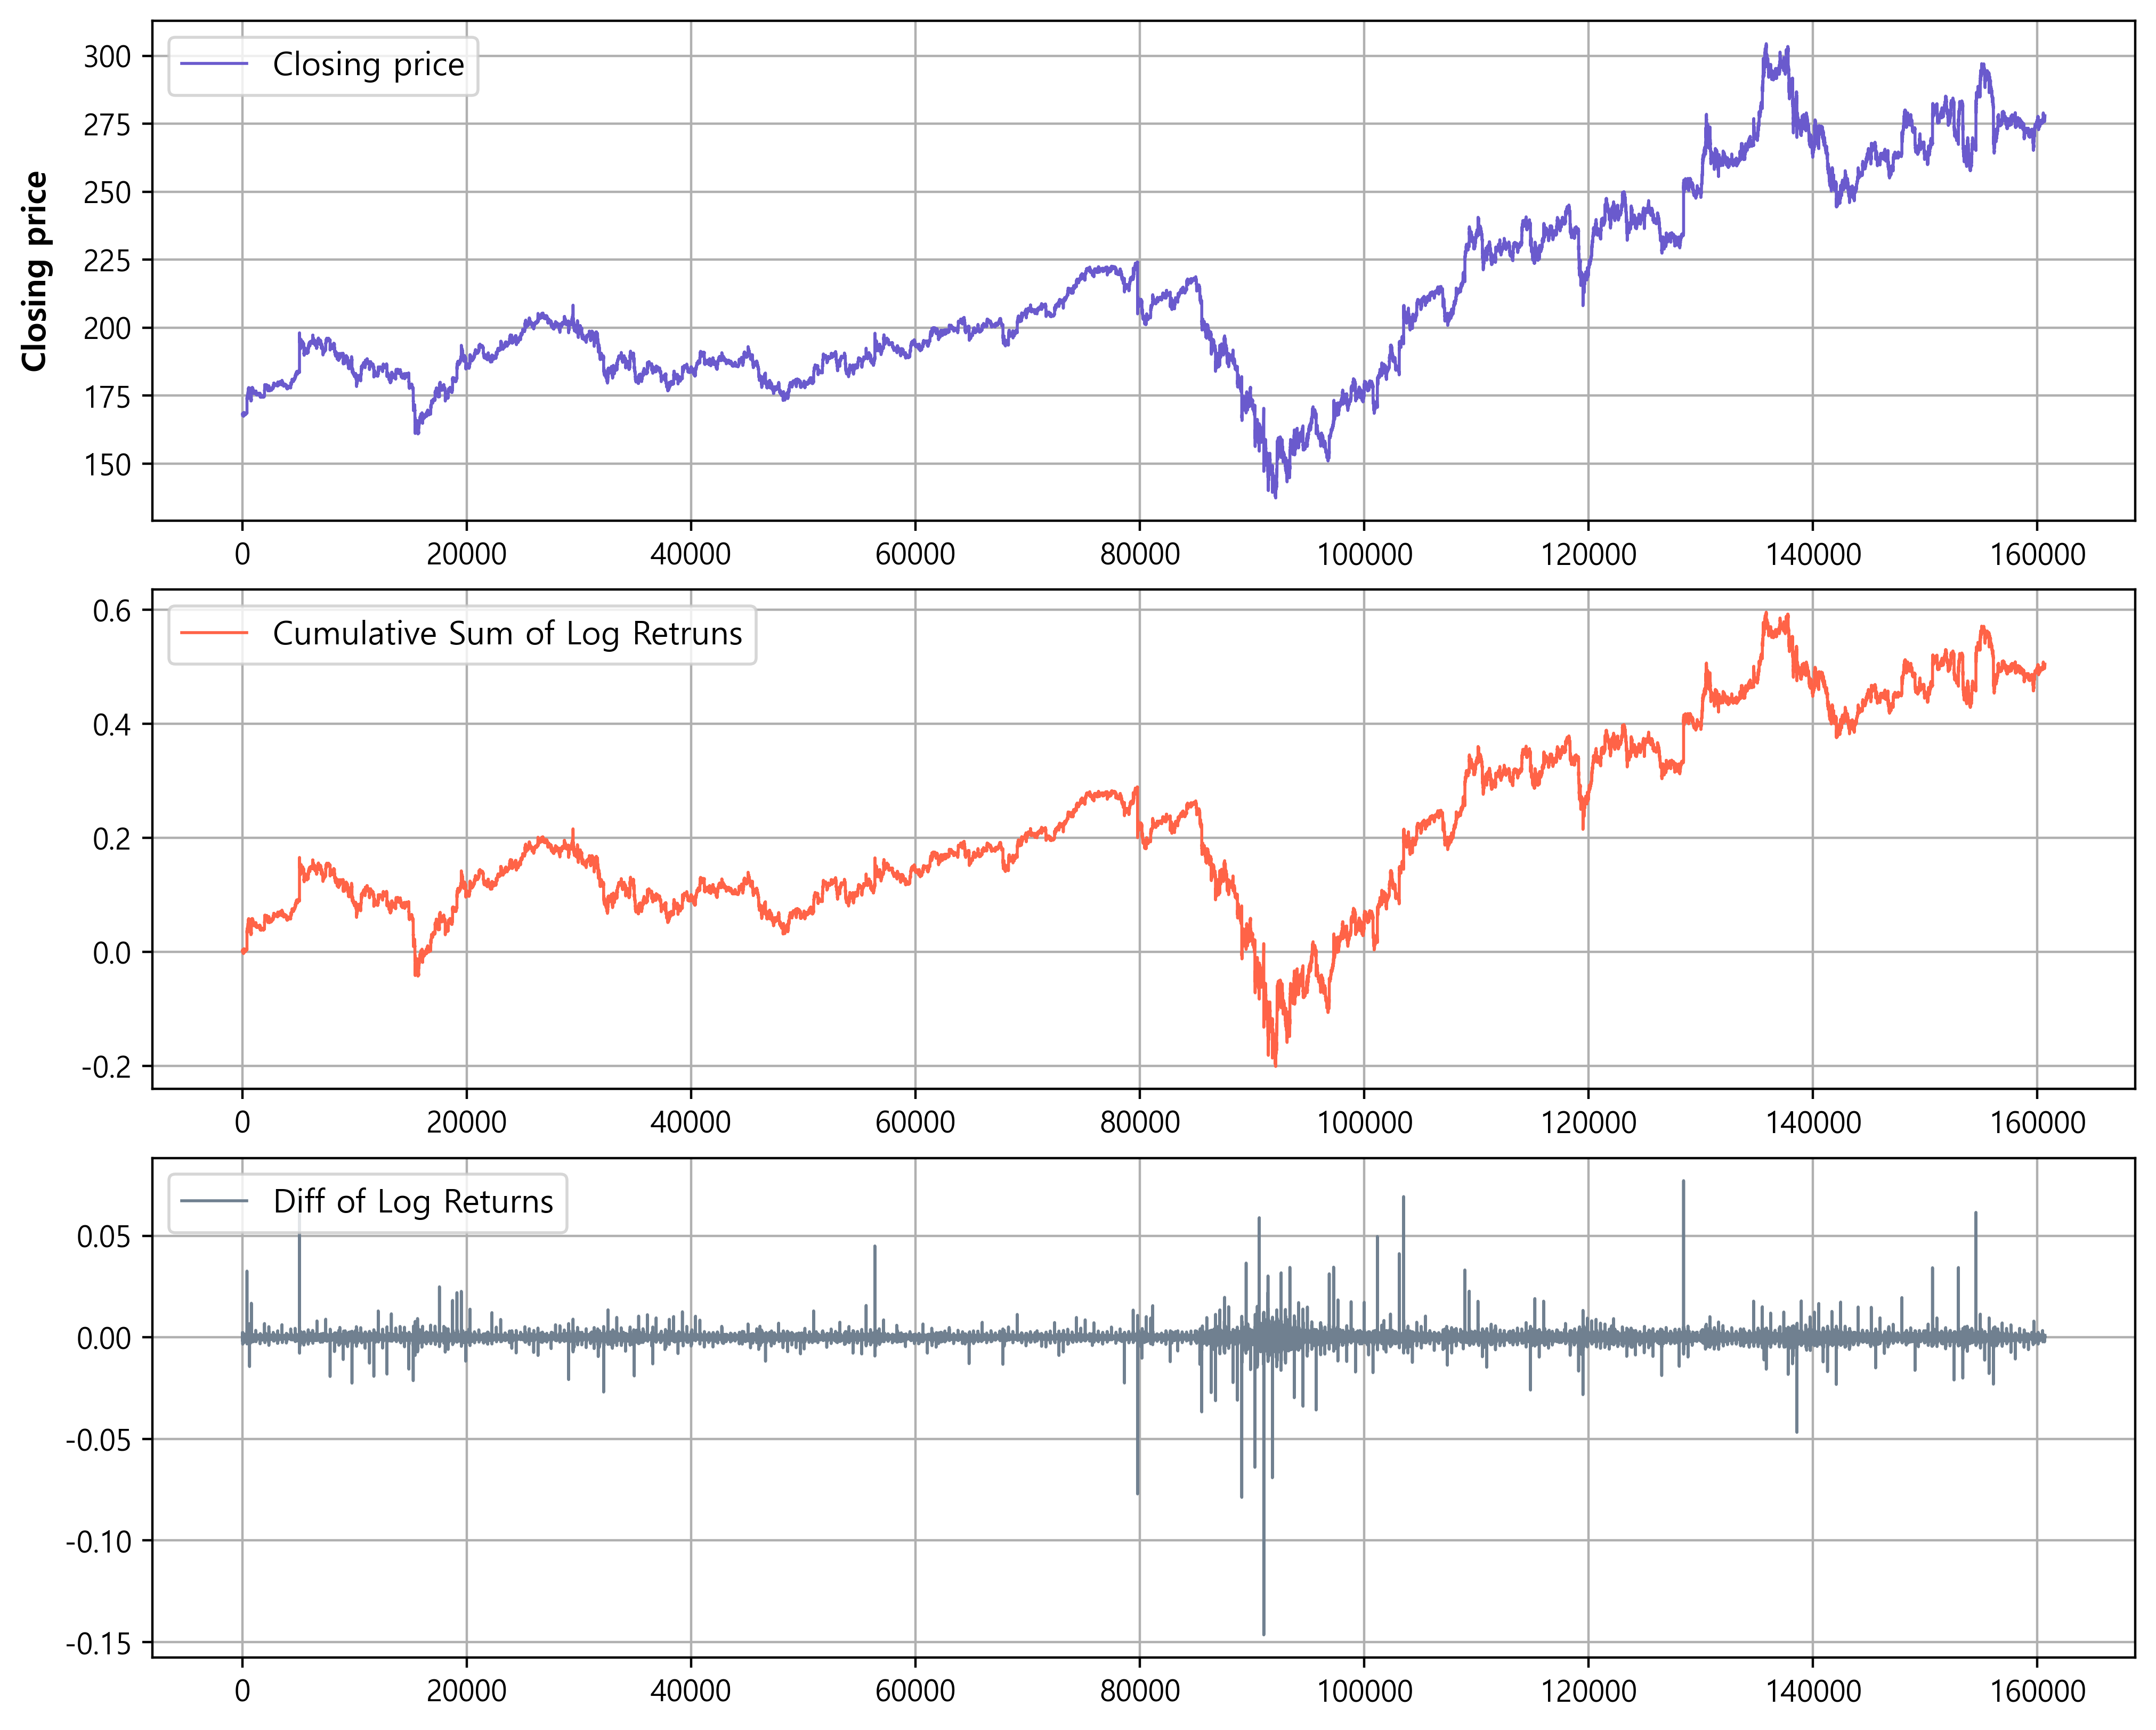

In [12]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,8), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(3,1,1)
ax1.plot(df['close'], color = 'slateblue', label='Closing price', lw = 1.0, alpha=1.0)
ax1.set_ylabel('Closing price', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='upper left', fontsize=legend_fontsize)
# ax1.set_title('순시전력 비교', fontsize=15, pad=12)
# ax1.set_ylim(-20, 270)
ax1.grid()

ax2 = fig.add_subplot(3,1,2)
ax2.plot(csum_logreturn, color = 'tomato', label='Cumulative Sum of Log Retruns', lw = 1.0, alpha=1.0)

ax2.tick_params(axis='x', labelsize=tick_labelsize)
ax2.tick_params(axis='y', labelsize=tick_labelsize)
ax2.legend(loc='upper left', fontsize=legend_fontsize)
# ax2.set_ylim(-20, 270)
ax2.grid()

ax3 = fig.add_subplot(3,1,3)
ax3.plot(logreturn, color = 'slategray', label='Diff of Log Returns', lw = 1.0, alpha=1.0)

ax3.tick_params(axis='x', labelsize=tick_labelsize)
ax3.tick_params(axis='y', labelsize=tick_labelsize)
ax3.legend(loc='upper left', fontsize=legend_fontsize)
# ax2.set_ylim(-20, 270)
ax3.grid()

plt.show()

# Parameter

In [13]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [14]:
train_data, val_data = get_data(logreturn, 0.6) # 60% train, 40% test split

In [25]:
val_data.shape

torch.Size([64260, 2, 10])

In [27]:
logreturn.shape

(160678,)

In [15]:
model = TransAm().to(device)
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs =  150 # Number of epochs

# Main

In [16]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % epochs == 0):  # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(
            epoch, (time.time() - epoch_start_time),                                         val_loss, math.exp(val_loss)))
        print('-' * 89)

    else:
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 89)
    scheduler.step()

| epoch   1 |    77/  385 batches | lr 0.000050 | 17.27 ms | loss 0.07361 | ppl     1.08
| epoch   1 |   154/  385 batches | lr 0.000050 |  9.78 ms | loss 0.01123 | ppl     1.01
| epoch   1 |   231/  385 batches | lr 0.000050 |  9.79 ms | loss 0.00849 | ppl     1.01
| epoch   1 |   308/  385 batches | lr 0.000050 |  9.95 ms | loss 0.00346 | ppl     1.00
| epoch   1 |   385/  385 batches | lr 0.000050 |  9.72 ms | loss 0.01317 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  4.35s
-----------------------------------------------------------------------------------------
| epoch   2 |    77/  385 batches | lr 0.000048 |  9.62 ms | loss 0.00562 | ppl     1.01
| epoch   2 |   154/  385 batches | lr 0.000048 |  9.59 ms | loss 0.00390 | ppl     1.00
| epoch   2 |   231/  385 batches | lr 0.000048 |  9.57 ms | loss 0.00257 | ppl     1.00
| epoch   2 |   308/  385 batches | lr 0.000048 |  9.46 ms | loss 0.00263 

| epoch  13 |   385/  385 batches | lr 0.000027 |  9.54 ms | loss 0.02172 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  13 | time:  3.67s
-----------------------------------------------------------------------------------------
| epoch  14 |    77/  385 batches | lr 0.000026 |  9.71 ms | loss 0.00696 | ppl     1.01
| epoch  14 |   154/  385 batches | lr 0.000026 |  9.88 ms | loss 0.00240 | ppl     1.00
| epoch  14 |   231/  385 batches | lr 0.000026 |  9.40 ms | loss 0.00234 | ppl     1.00
| epoch  14 |   308/  385 batches | lr 0.000026 |  9.53 ms | loss 0.00104 | ppl     1.00
| epoch  14 |   385/  385 batches | lr 0.000026 |  9.48 ms | loss 0.02483 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  14 | time:  3.70s
-----------------------------------------------------------------------------------------
| epoch  15 |    77/  385 batches | lr

| epoch  26 |    77/  385 batches | lr 0.000014 |  9.59 ms | loss 0.00098 | ppl     1.00
| epoch  26 |   154/  385 batches | lr 0.000014 |  9.49 ms | loss 0.00057 | ppl     1.00
| epoch  26 |   231/  385 batches | lr 0.000014 |  9.22 ms | loss 0.00048 | ppl     1.00
| epoch  26 |   308/  385 batches | lr 0.000014 |  9.61 ms | loss 0.00053 | ppl     1.00
| epoch  26 |   385/  385 batches | lr 0.000014 | 10.13 ms | loss 0.00558 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  26 | time:  3.70s
-----------------------------------------------------------------------------------------
| epoch  27 |    77/  385 batches | lr 0.000013 | 10.28 ms | loss 0.00083 | ppl     1.00
| epoch  27 |   154/  385 batches | lr 0.000013 |  9.62 ms | loss 0.00050 | ppl     1.00
| epoch  27 |   231/  385 batches | lr 0.000013 |  9.46 ms | loss 0.00040 | ppl     1.00
| epoch  27 |   308/  385 batches | lr 0.000013 |  9.55 ms | loss 0.00050 

| epoch  38 |   385/  385 batches | lr 0.000007 |  9.86 ms | loss 0.00184 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  38 | time:  3.69s
-----------------------------------------------------------------------------------------
| epoch  39 |    77/  385 batches | lr 0.000007 |  9.38 ms | loss 0.00041 | ppl     1.00
| epoch  39 |   154/  385 batches | lr 0.000007 |  9.32 ms | loss 0.00019 | ppl     1.00
| epoch  39 |   231/  385 batches | lr 0.000007 |  9.39 ms | loss 0.00013 | ppl     1.00
| epoch  39 |   308/  385 batches | lr 0.000007 |  9.26 ms | loss 0.00024 | ppl     1.00
| epoch  39 |   385/  385 batches | lr 0.000007 |  9.46 ms | loss 0.00172 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  39 | time:  3.60s
-----------------------------------------------------------------------------------------
| epoch  40 |    77/  385 batches | lr

| epoch  51 |    77/  385 batches | lr 0.000004 |  9.57 ms | loss 0.00026 | ppl     1.00
| epoch  51 |   154/  385 batches | lr 0.000004 |  9.41 ms | loss 0.00011 | ppl     1.00
| epoch  51 |   231/  385 batches | lr 0.000004 |  9.33 ms | loss 0.00008 | ppl     1.00
| epoch  51 |   308/  385 batches | lr 0.000004 |  9.55 ms | loss 0.00018 | ppl     1.00
| epoch  51 |   385/  385 batches | lr 0.000004 |  9.37 ms | loss 0.00091 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  3.64s
-----------------------------------------------------------------------------------------
| epoch  52 |    77/  385 batches | lr 0.000004 |  9.62 ms | loss 0.00024 | ppl     1.00
| epoch  52 |   154/  385 batches | lr 0.000004 |  9.34 ms | loss 0.00011 | ppl     1.00
| epoch  52 |   231/  385 batches | lr 0.000004 |  9.75 ms | loss 0.00008 | ppl     1.00
| epoch  52 |   308/  385 batches | lr 0.000004 |  9.20 ms | loss 0.00018 

| epoch  63 |   385/  385 batches | lr 0.000002 |  9.64 ms | loss 0.00055 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  63 | time:  3.64s
-----------------------------------------------------------------------------------------
| epoch  64 |    77/  385 batches | lr 0.000002 |  9.22 ms | loss 0.00014 | ppl     1.00
| epoch  64 |   154/  385 batches | lr 0.000002 |  9.28 ms | loss 0.00007 | ppl     1.00
| epoch  64 |   231/  385 batches | lr 0.000002 |  9.40 ms | loss 0.00006 | ppl     1.00
| epoch  64 |   308/  385 batches | lr 0.000002 |  9.27 ms | loss 0.00017 | ppl     1.00
| epoch  64 |   385/  385 batches | lr 0.000002 |  9.22 ms | loss 0.00053 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  64 | time:  3.57s
-----------------------------------------------------------------------------------------
| epoch  65 |    77/  385 batches | lr

| epoch  76 |    77/  385 batches | lr 0.000001 |  9.48 ms | loss 0.00012 | ppl     1.00
| epoch  76 |   154/  385 batches | lr 0.000001 |  9.26 ms | loss 0.00007 | ppl     1.00
| epoch  76 |   231/  385 batches | lr 0.000001 |  9.49 ms | loss 0.00006 | ppl     1.00
| epoch  76 |   308/  385 batches | lr 0.000001 |  9.14 ms | loss 0.00016 | ppl     1.00
| epoch  76 |   385/  385 batches | lr 0.000001 |  9.22 ms | loss 0.00045 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  76 | time:  3.59s
-----------------------------------------------------------------------------------------
| epoch  77 |    77/  385 batches | lr 0.000001 |  9.72 ms | loss 0.00012 | ppl     1.00
| epoch  77 |   154/  385 batches | lr 0.000001 |  9.64 ms | loss 0.00007 | ppl     1.00
| epoch  77 |   231/  385 batches | lr 0.000001 |  9.68 ms | loss 0.00006 | ppl     1.00
| epoch  77 |   308/  385 batches | lr 0.000001 |  9.56 ms | loss 0.00016 

| epoch  88 |   385/  385 batches | lr 0.000001 |  9.49 ms | loss 0.00043 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  88 | time:  3.60s
-----------------------------------------------------------------------------------------
| epoch  89 |    77/  385 batches | lr 0.000001 |  9.81 ms | loss 0.00011 | ppl     1.00
| epoch  89 |   154/  385 batches | lr 0.000001 |  9.55 ms | loss 0.00006 | ppl     1.00
| epoch  89 |   231/  385 batches | lr 0.000001 |  9.40 ms | loss 0.00006 | ppl     1.00
| epoch  89 |   308/  385 batches | lr 0.000001 |  9.22 ms | loss 0.00016 | ppl     1.00
| epoch  89 |   385/  385 batches | lr 0.000001 |  9.28 ms | loss 0.00043 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  89 | time:  3.64s
-----------------------------------------------------------------------------------------
| epoch  90 |    77/  385 batches | lr

| epoch 101 |    77/  385 batches | lr 0.000000 |  9.57 ms | loss 0.00011 | ppl     1.00
| epoch 101 |   154/  385 batches | lr 0.000000 |  9.31 ms | loss 0.00006 | ppl     1.00
| epoch 101 |   231/  385 batches | lr 0.000000 |  9.10 ms | loss 0.00005 | ppl     1.00
| epoch 101 |   308/  385 batches | lr 0.000000 |  9.46 ms | loss 0.00016 | ppl     1.00
| epoch 101 |   385/  385 batches | lr 0.000000 |  9.36 ms | loss 0.00041 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 101 | time:  3.60s
-----------------------------------------------------------------------------------------
| epoch 102 |    77/  385 batches | lr 0.000000 |  9.46 ms | loss 0.00011 | ppl     1.00
| epoch 102 |   154/  385 batches | lr 0.000000 |  9.09 ms | loss 0.00006 | ppl     1.00
| epoch 102 |   231/  385 batches | lr 0.000000 |  9.26 ms | loss 0.00005 | ppl     1.00
| epoch 102 |   308/  385 batches | lr 0.000000 |  9.11 ms | loss 0.00016 

| epoch 113 |   385/  385 batches | lr 0.000000 |  9.59 ms | loss 0.00040 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 113 | time:  3.58s
-----------------------------------------------------------------------------------------
| epoch 114 |    77/  385 batches | lr 0.000000 |  9.49 ms | loss 0.00010 | ppl     1.00
| epoch 114 |   154/  385 batches | lr 0.000000 |  9.27 ms | loss 0.00007 | ppl     1.00
| epoch 114 |   231/  385 batches | lr 0.000000 |  9.24 ms | loss 0.00006 | ppl     1.00
| epoch 114 |   308/  385 batches | lr 0.000000 |  9.28 ms | loss 0.00016 | ppl     1.00
| epoch 114 |   385/  385 batches | lr 0.000000 |  9.40 ms | loss 0.00039 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 114 | time:  3.59s
-----------------------------------------------------------------------------------------
| epoch 115 |    77/  385 batches | lr

| epoch 126 |    77/  385 batches | lr 0.000000 |  9.73 ms | loss 0.00010 | ppl     1.00
| epoch 126 |   154/  385 batches | lr 0.000000 |  9.45 ms | loss 0.00007 | ppl     1.00
| epoch 126 |   231/  385 batches | lr 0.000000 |  9.44 ms | loss 0.00006 | ppl     1.00
| epoch 126 |   308/  385 batches | lr 0.000000 |  9.31 ms | loss 0.00016 | ppl     1.00
| epoch 126 |   385/  385 batches | lr 0.000000 |  9.36 ms | loss 0.00040 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 126 | time:  3.64s
-----------------------------------------------------------------------------------------
| epoch 127 |    77/  385 batches | lr 0.000000 |  9.52 ms | loss 0.00010 | ppl     1.00
| epoch 127 |   154/  385 batches | lr 0.000000 |  9.35 ms | loss 0.00007 | ppl     1.00
| epoch 127 |   231/  385 batches | lr 0.000000 |  9.31 ms | loss 0.00006 | ppl     1.00
| epoch 127 |   308/  385 batches | lr 0.000000 |  9.86 ms | loss 0.00015 

| epoch 138 |   385/  385 batches | lr 0.000000 |  9.52 ms | loss 0.00039 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 138 | time:  3.63s
-----------------------------------------------------------------------------------------
| epoch 139 |    77/  385 batches | lr 0.000000 |  9.53 ms | loss 0.00010 | ppl     1.00
| epoch 139 |   154/  385 batches | lr 0.000000 | 10.19 ms | loss 0.00007 | ppl     1.00
| epoch 139 |   231/  385 batches | lr 0.000000 |  9.94 ms | loss 0.00006 | ppl     1.00
| epoch 139 |   308/  385 batches | lr 0.000000 |  9.45 ms | loss 0.00015 | ppl     1.00
| epoch 139 |   385/  385 batches | lr 0.000000 |  9.53 ms | loss 0.00039 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 139 | time:  3.74s
-----------------------------------------------------------------------------------------
| epoch 140 |    77/  385 batches | lr

In [17]:
test_result, truth = forecast_seq(model, val_data)

95.88230729103088 sec


# Visualization

## Plot forecasted sequence vs actual

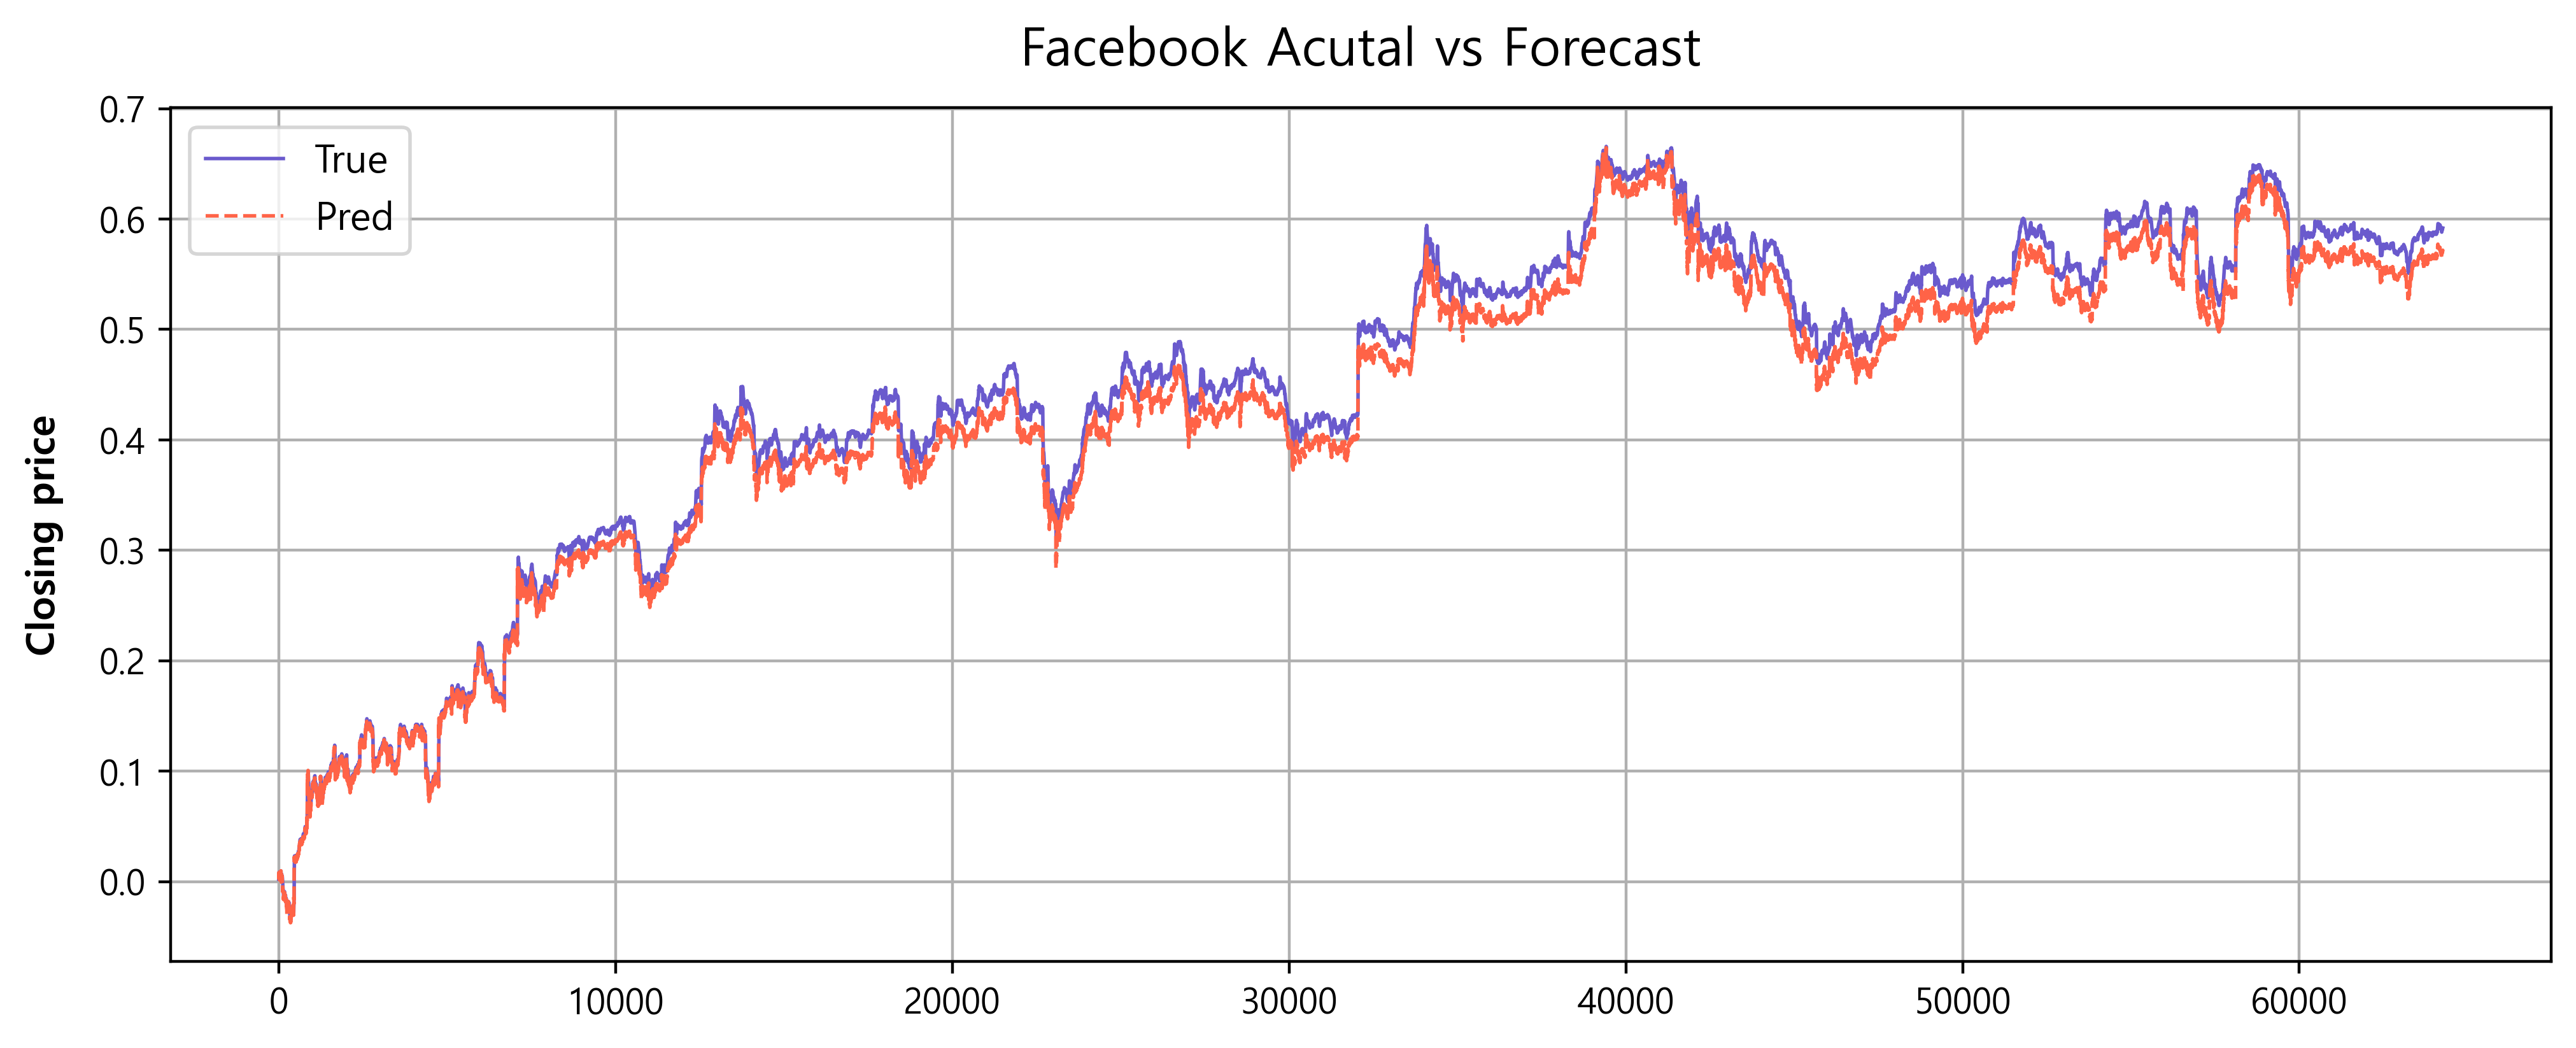

In [76]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(test_result, color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax1.plot(truth, color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax1.set_ylabel('Closing price', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('Facebook Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_title('순시전력 비교', fontsize=15, pad=12)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()

## Test random sequence

forecast sequence: [0.34093982 0.3411093  0.34271792 0.3428025  0.34284478 0.34284478
 0.34089744 0.33956176 0.34093982 0.3393708  0.35288352]
Actual sequence: [0.34093983 0.34110931 0.34271791 0.3428025  0.34284479 0.34284479
 0.34089745 0.33956176 0.34093983 0.3393708  0.34034643]


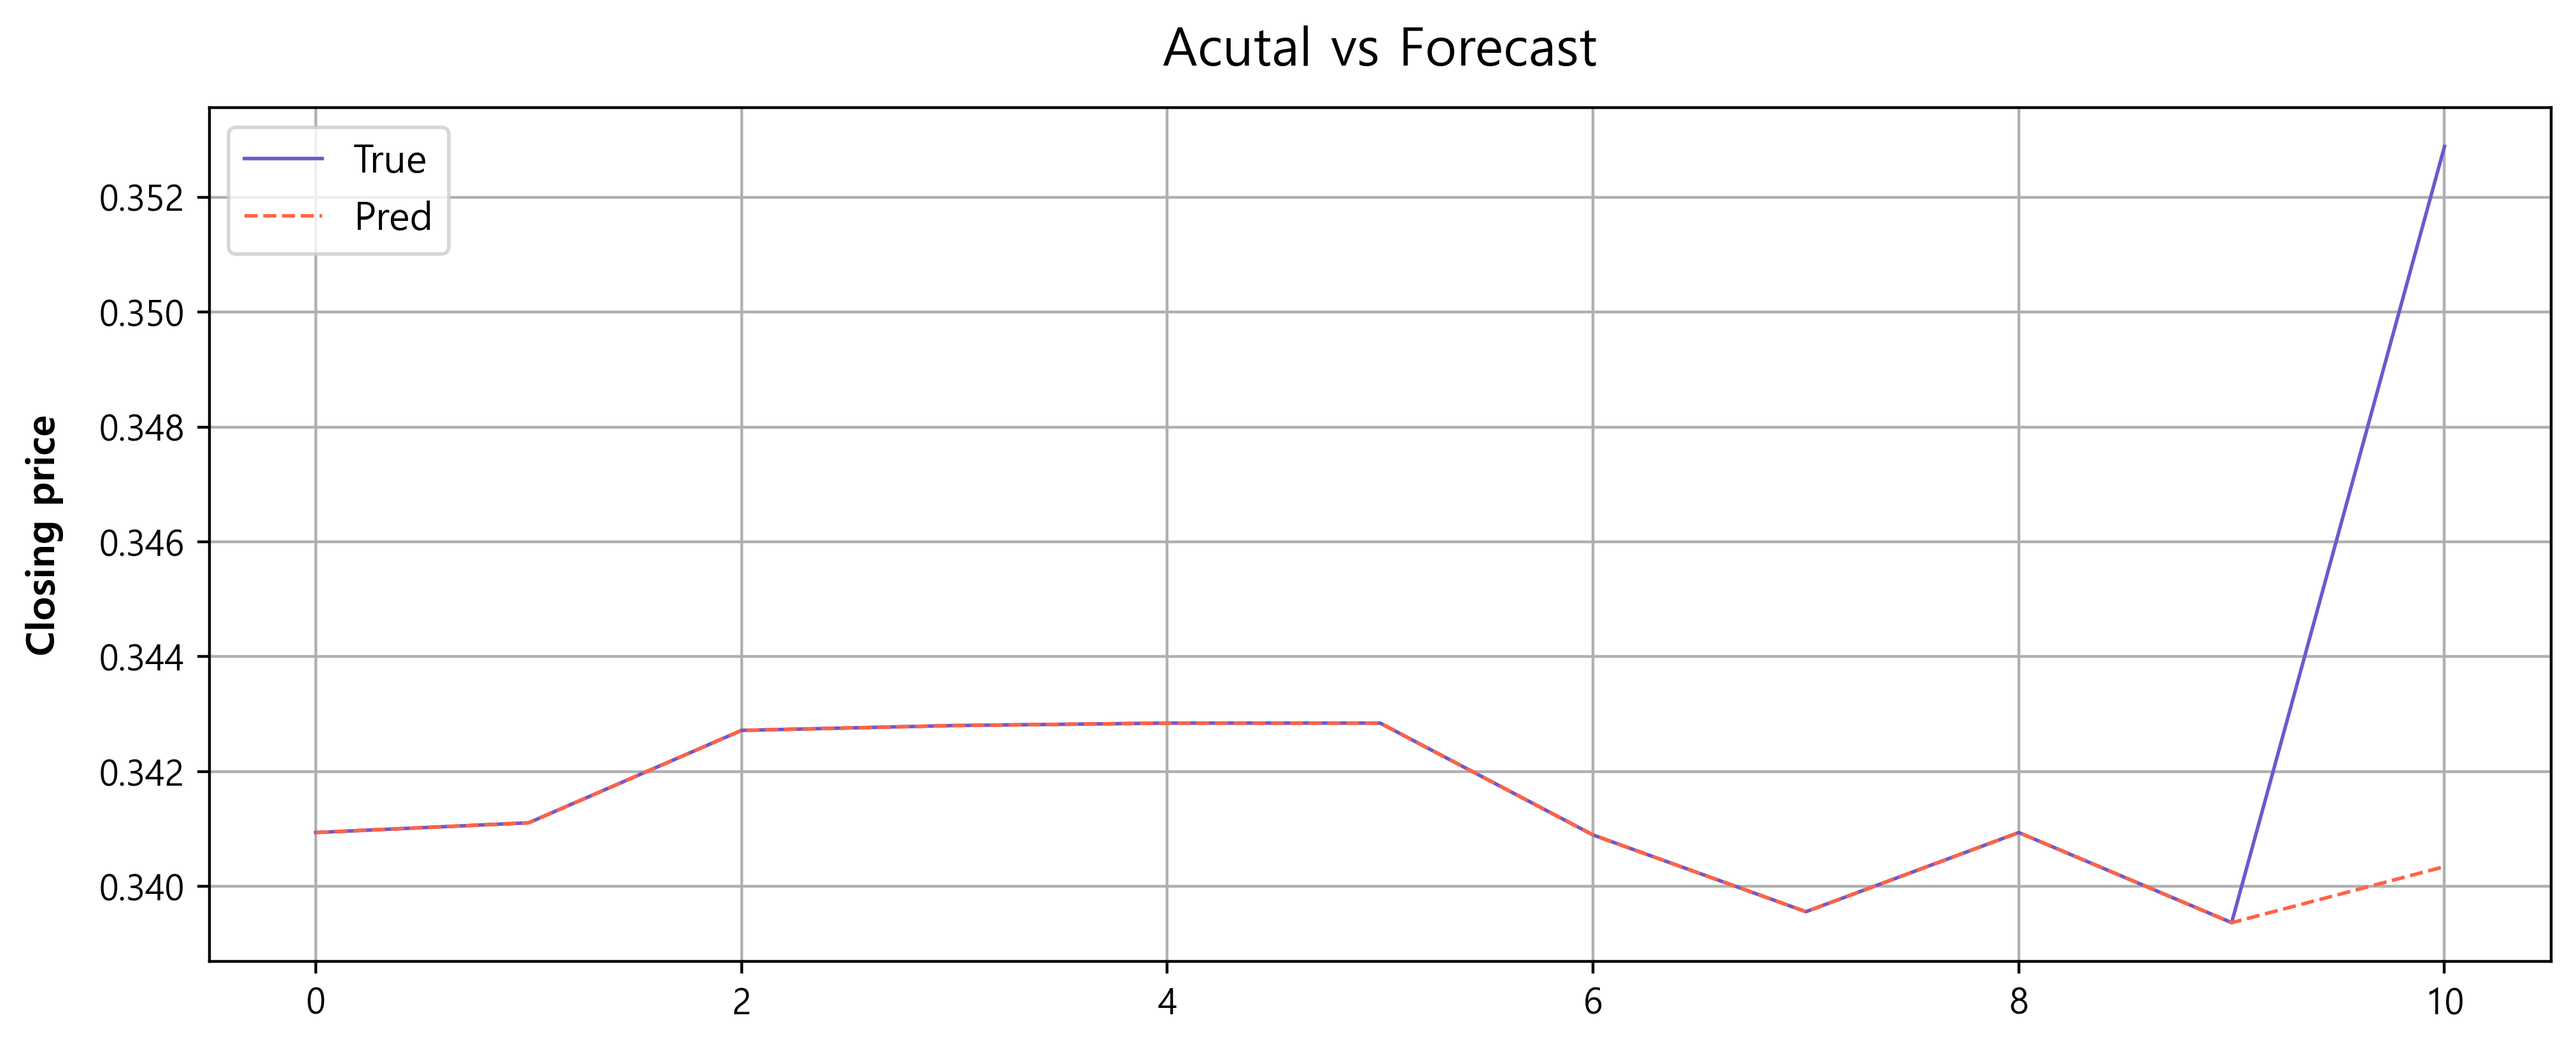

In [20]:
r = np.random.randint(100000, 160000)
test_forecast = model_forecast(model, csum_logreturn[r: r+10]) # random 10 sequence length

print(f"forecast sequence: {test_forecast}")
print(f"Actual sequence: {csum_logreturn[r: r+11]}")

##########
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(test_forecast, color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax1.plot(csum_logreturn[r:r+11], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax1.set_ylabel('Closing price', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_title('순시전력 비교', fontsize=15, pad=12)
# ax1.set_ylim(-20, 270)
ax1.grid()


## Save the model

In [21]:
torch.save(model.state_dict(), "transformer_ts.pth")

# Test with other data

## Load model

In [63]:
model2 = TransAm() # rename as model2
model2.load_state_dict(torch.load("transformer_ts.pth"))
model2.to(device)

TransAm(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (

In [64]:
df2 = pd.read_csv('BA_raw.csv') # Boeing Co stock
close2 = df2['close'].fillna(method = 'ffill')
close2 = np.array(close2)
logreturn2 = np.diff(np.log(close2))

In [68]:
train_data2, val_data2 = get_data(logreturn2, 0.6)
test2_eval = evaluate(model2, val_data2)
print(f'Test 2 loss: {test2_eval :.5f}')

Test 2 loss: 0.00009


In [69]:
test_result2, truth2 = forecast_seq(model2, val_data2)

132.08676385879517 sec


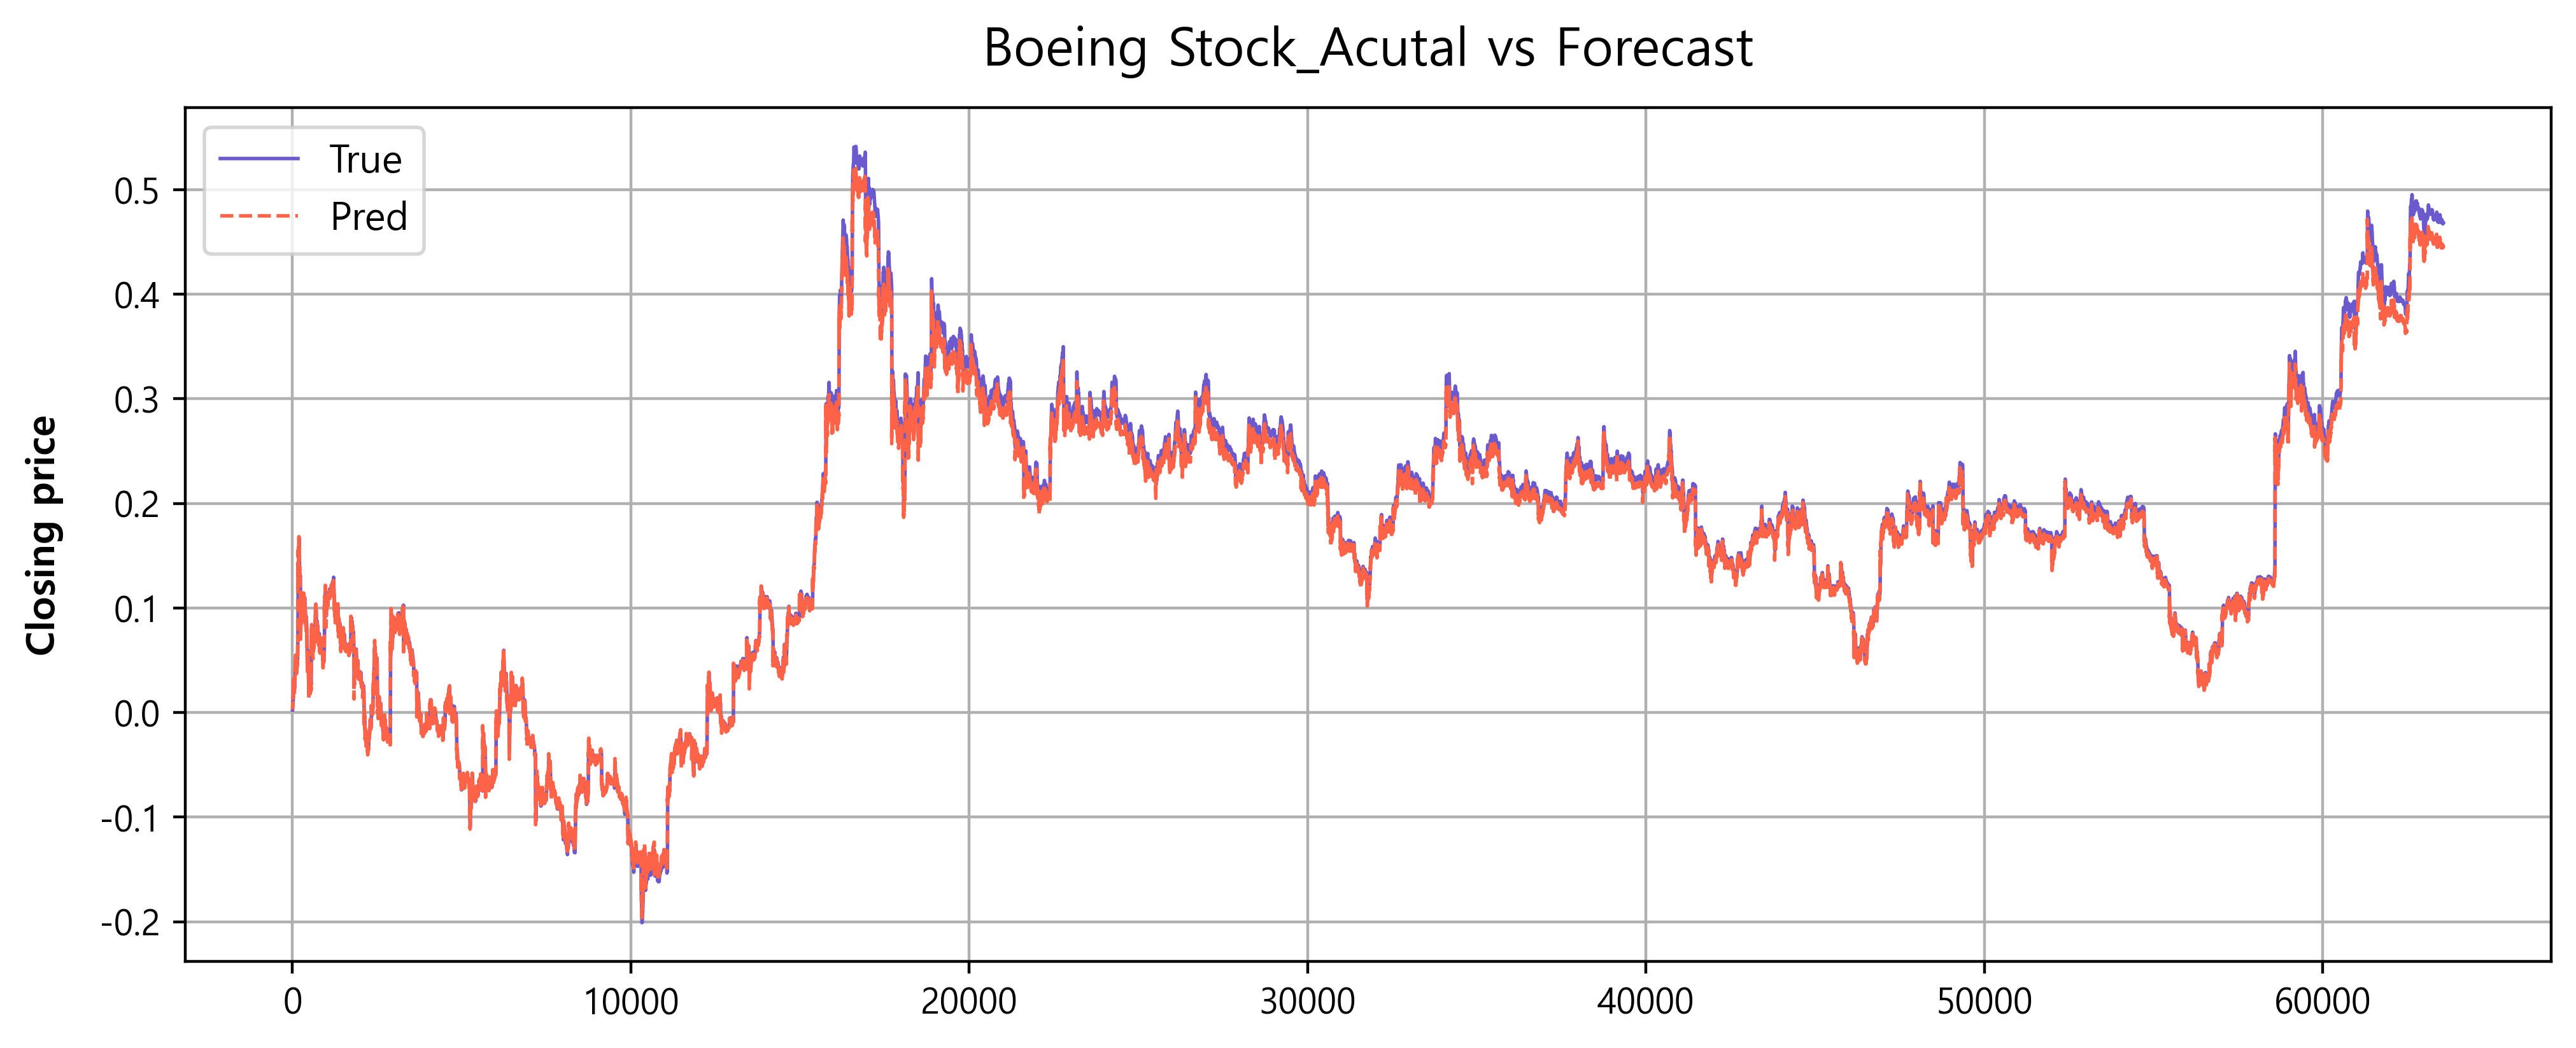

In [73]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(test_result2, color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax1.plot(truth2, color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax1.set_ylabel('Closing price', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('Boeing Stock_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_title('순시전력 비교', fontsize=15, pad=12)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()

In [71]:
df3 = pd.read_csv('JPM_raw.csv') # JPMorgan Chase & Co stock
close3 = df3['close'].fillna(method = 'ffill')
close3 = np.array(close3)
logreturn3 = np.diff(np.log(close3))

In [72]:
train_data3, val_data3 = get_data(logreturn3, 0.6)
test3_eval = evaluate(model2, val_data3)
print(f'Test 3 loss: {test3_eval :.5f}')

Test 3 loss: 0.00002


In [74]:
test_result3, truth3 = forecast_seq(model2, val_data3)

135.62072205543518 sec


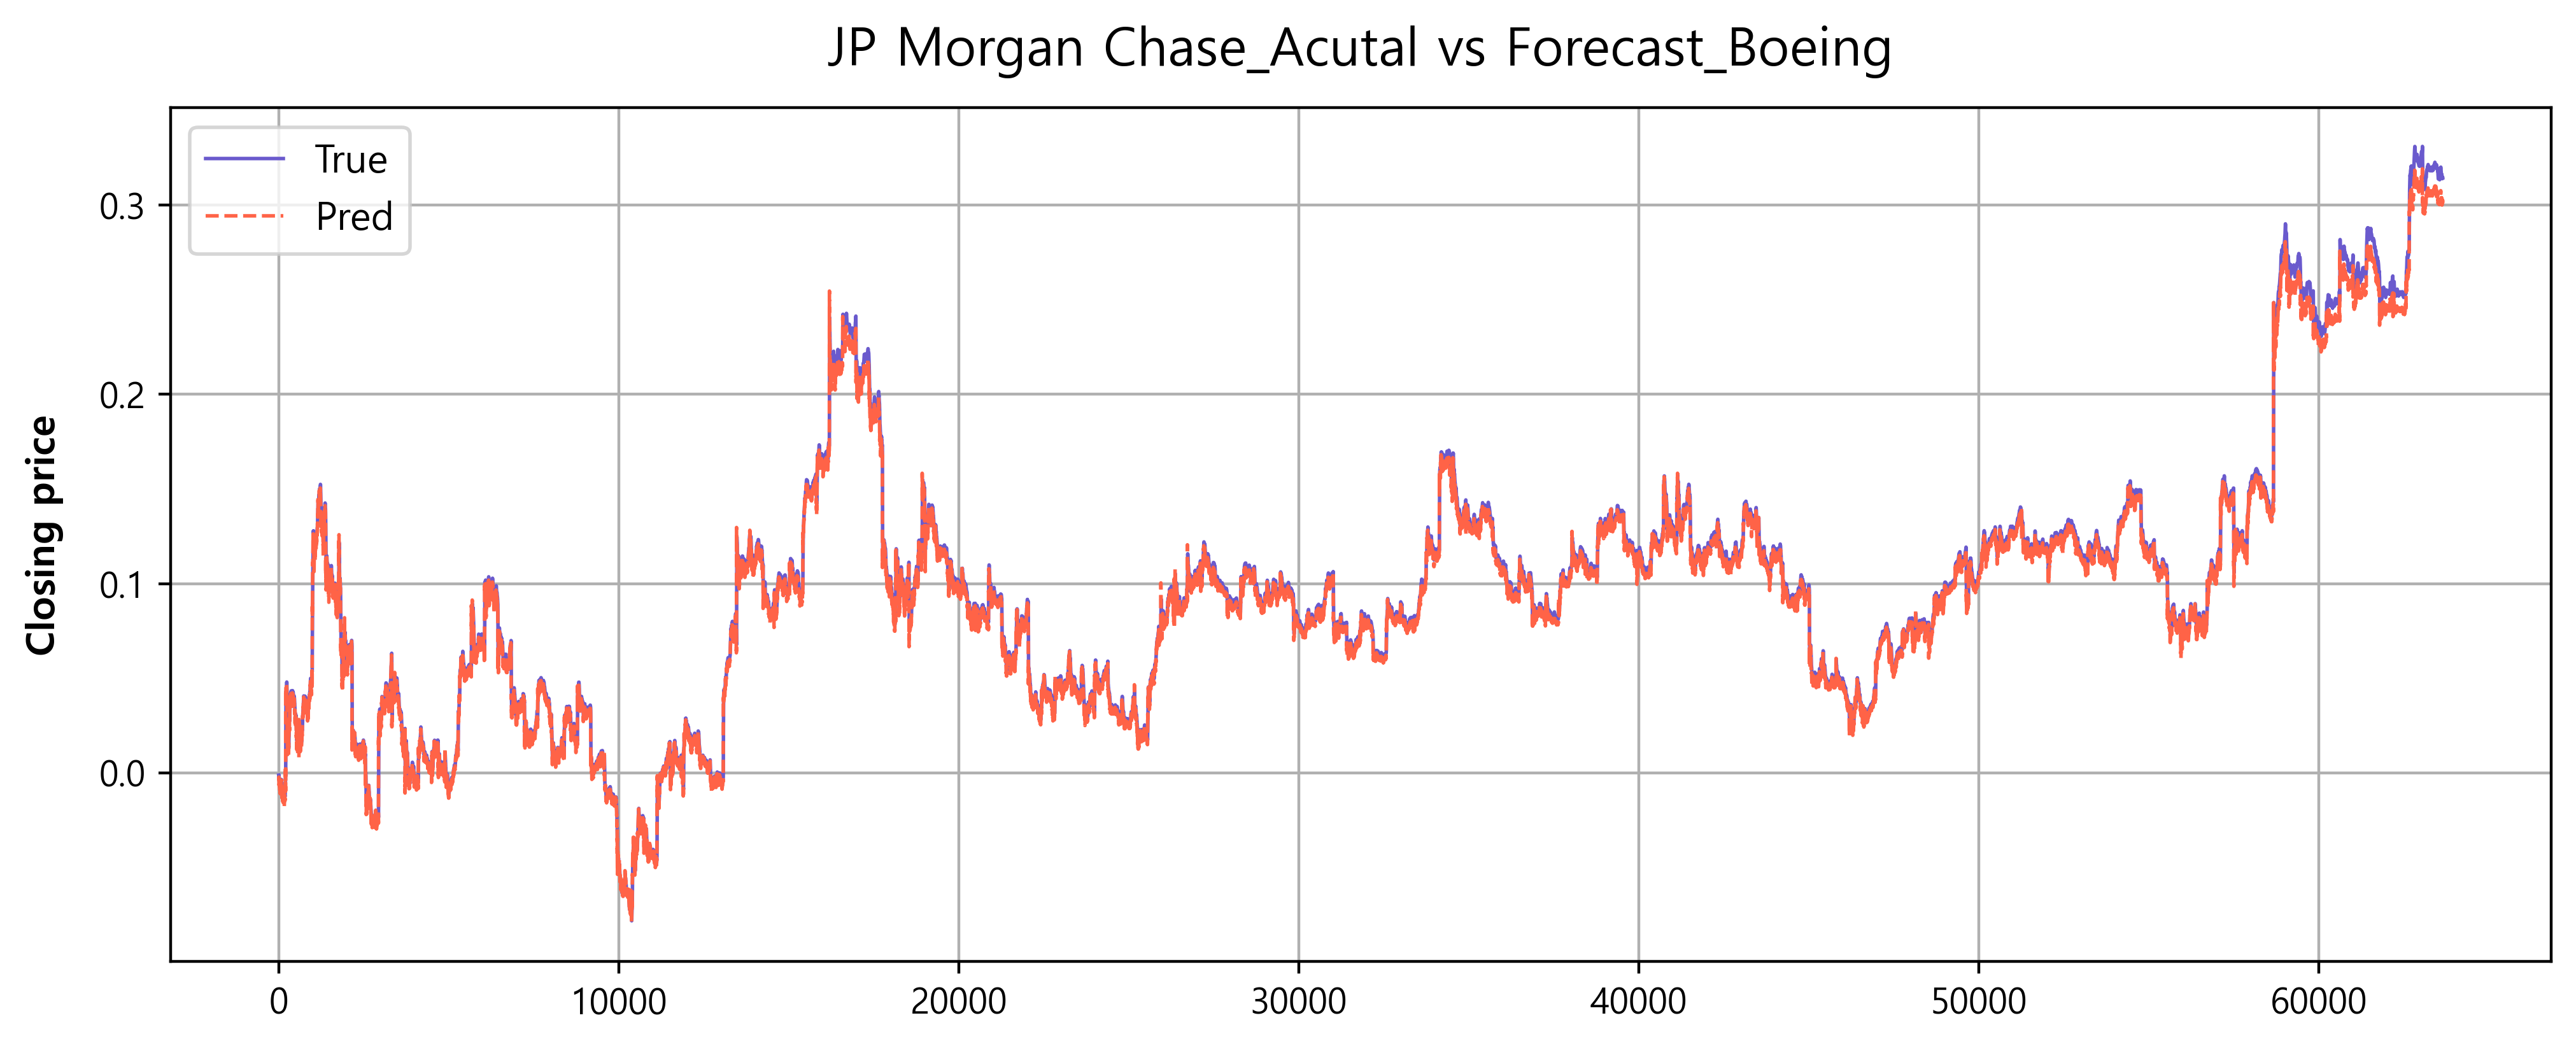

In [75]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(test_result3, color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax1.plot(truth3, color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax1.set_ylabel('Closing price', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('JP Morgan Chase_Acutal vs Forecast_Boeing', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_title('순시전력 비교', fontsize=15, pad=12)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()